# Import Library

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense,Dropout,BatchNormalization, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D

# Membuka Dataset Hasil Stemming

In [ ]:
df = pd.read_csv('dataset_swch_roberta_ayame.csv',delimiter=';')
df

,Unnamed: 0,Stemming,label
0,0,shelaemeliana sehat iya sandwich generation,Neutral
1,1,film rumah swet loan recomended gusy nonton ta...,Neutral
2,2,tanyakanrl teman sandwich generation hedon,Neutral
3,3,kabar iya kakak kakak garuda soft spoken sandw...,Neutral
4,4,film bagus kali menang huhu misuhmisuhinkeluar...,Positive
...,...,...,...
1407,1407,idola perempuanperempuan dady isue sandwich ge...,Neutral
1408,1408,convomf anak of kursus sandwich generation,Neutral
1409,1409,convomf anak of kursus sandwich generation,Neutral
1410,1410,inipita biar enak bada badane suka gel gel san...,Positive


# Pre-Proses Dataset

In [ ]:
del df ['Unnamed: 0']
df

,Stemming,label
0,shelaemeliana sehat iya sandwich generation,Neutral
1,film rumah swet loan recomended gusy nonton ta...,Neutral
2,tanyakanrl teman sandwich generation hedon,Neutral
3,kabar iya kakak kakak garuda soft spoken sandw...,Neutral
4,film bagus kali menang huhu misuhmisuhinkeluar...,Positive
...,...,...
1407,idola perempuanperempuan dady isue sandwich ge...,Neutral
1408,convomf anak of kursus sandwich generation,Neutral
1409,convomf anak of kursus sandwich generation,Neutral
1410,inipita biar enak bada badane suka gel gel san...,Positive


In [ ]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Stemming,label
0,shelaemeliana sehat iya sandwich generation,Neutral
1,film rumah swet loan recomended gusy nonton ta...,Neutral
2,tanyakanrl teman sandwich generation hedon,Neutral
3,kabar iya kakak kakak garuda soft spoken sandw...,Neutral
4,film bagus kali menang huhu misuhmisuhinkeluar...,Positive
...,...,...
1407,idola perempuanperempuan dady isue sandwich ge...,Neutral
1408,convomf anak of kursus sandwich generation,Neutral
1409,convomf anak of kursus sandwich generation,Neutral
1410,inipita biar enak bada badane suka gel gel san...,Positive


In [ ]:
df['label'].value_counts()

,count
label,
Neutral,640
Negative,513
Positive,259


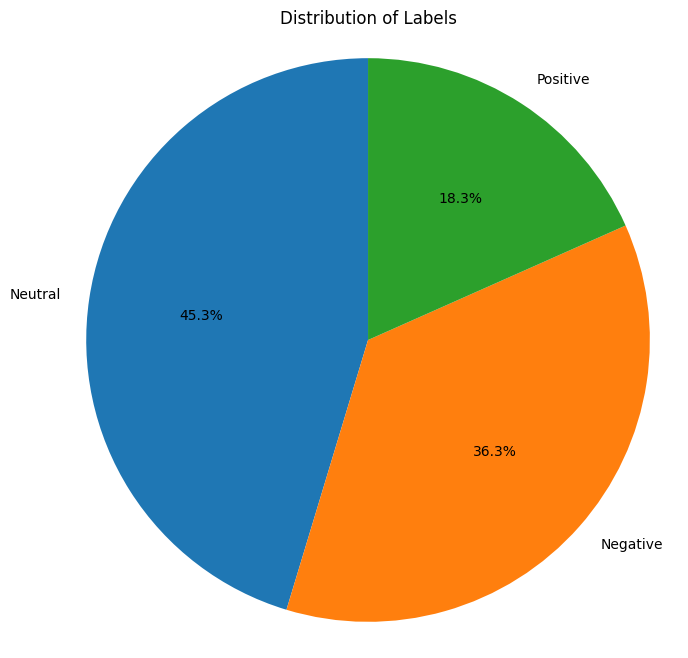

In [ ]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Labels')
plt.axis('equal')
plt.show()

# Data Augmentasi Untuk Memperkaya Data

In [ ]:
import random
import nltk
from nltk.corpus import wordnet

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
def synonym_replacement(text):
    words = nltk.word_tokenize(text)  # Tokenisasi kalimat menjadi kata-kata
    new_words = words.copy()

    for word in words:
        # Mengambil sinonim dari WordNet
        synonyms = wordnet.synsets(word)
        if synonyms:
            # Ambil satu sinonim secara acak
            synonym = random.choice(synonyms).lemmas()[0].name()  # Ambil sinonim pertama
            new_words = [synonym if w == word else w for w in new_words]

    return ' '.join(new_words)

# Lakukan augmentasi pada dataset
augmented_texts = []
for text in df['Stemming']:
    augmented_texts.append(synonym_replacement(text))

# Buat DataFrame baru untuk menampung teks augmented
augmented_df = pd.DataFrame({
    'Stemming': augmented_texts,
    'label': df['label']  # Tetap menggunakan label asli
})

# Gabungkan dengan DataFrame asli
combined_df = pd.concat([df, augmented_df], ignore_index=True)

# Tampilkan hasil augmentasi
print(combined_df)

                                               Stemming     label
0           shelaemeliana sehat iya sandwich generation   Neutral
1     film rumah swet loan recomended gusy nonton ta...   Neutral
2            tanyakanrl teman sandwich generation hedon   Neutral
3     kabar iya kakak kakak garuda soft spoken sandw...   Neutral
4     film bagus kali menang huhu misuhmisuhinkeluar...  Positive
...                                                 ...       ...
2819  idola perempuanperempuan dady isue sandwich ge...   Neutral
2820         convomf anak of kursus sandwich generation   Neutral
2821            convomf anak of kursus sandwich coevals   Neutral
2822  inipita biar enak bada badane suka mousse mous...  Positive
2823  repair kost actinium not actinium asumsi gaji ...  Negative

[2824 rows x 2 columns]


Merubah data teks menjadi vektor untuk diolah

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X_vectorized = vectorizer.fit_transform(combined_df['Stemming']).toarray()
X_vectorized

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Merubah label menjadi kode numerik

In [ ]:
# Konversi label menjadi format numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(combined_df['label'])
y_encoded

array([1, 1, 1, ..., 1, 2, 0])

# Pemerataan Data Minor Agara Data Seimbang untuk Diolah

In [ ]:
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
# Terapkan SMOTE pada data vektor
smote = SMOTE(sampling_strategy='minority', random_state=32)
X_smote, y_smote = smote.fit_resample(X_vectorized, y_encoded)
pd.value_counts(y_smote)

<ipython-input-12-6d58dc942d7a>:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y_smote)


,count
1,1280
2,1280
0,1026


<ipython-input-13-c4ca6110d5ba>:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  label_counts_smote = pd.value_counts(y_smote)


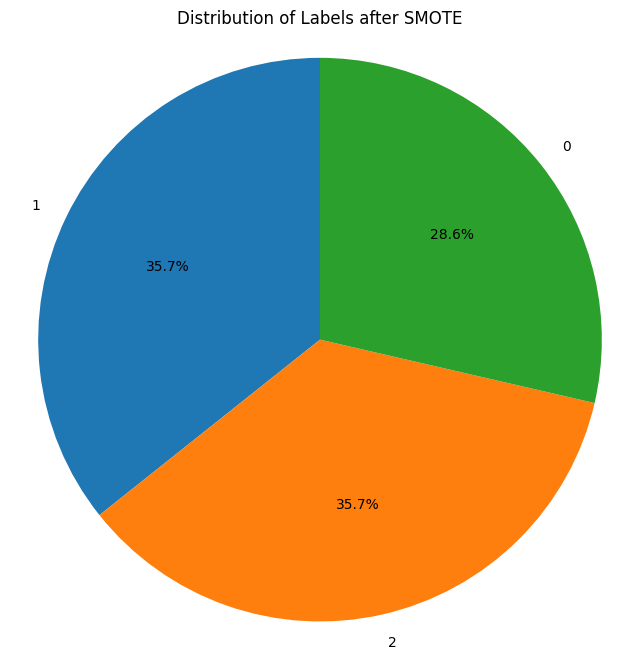

In [ ]:
import matplotlib.pyplot as plt

label_counts_smote = pd.value_counts(y_smote)

plt.figure(figsize=(8, 8))
plt.pie(label_counts_smote, labels=label_counts_smote.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Labels after SMOTE')
plt.axis('equal')
plt.show()

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# Hitung class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_smote),
    y=y_smote
)

# Ubah menjadi dictionary agar dapat digunakan dalam `fit`
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)

Class weights: {0: 1.165042235217674, 1: 0.9338541666666667, 2: 0.9338541666666667}


In [ ]:
# Split data hasil SMOTE untuk pelatihan dan validasi
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

Konversi Label hasil split data dan melakukan penyesuaian bentuk pada variabel X agar sesuai untuk input LSTM

In [ ]:
# Mengonversi label ke one-hot encoding
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)

In [ ]:
# Bentuk ulang X_train dan X_val untuk input LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Model LSTM

Model untuk melakukan pengujian data dengan melihat perbandingan tiap batch dengan ketentuan menggunakan neuron 100 dan epoch 50 untuk menguji pada ukuran batch 32, 64, 128

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
import tensorflow as tf

# Jumlah neuron yang akan digunakan
neurons = 100
batch_sizes = [32, 64, 128]
results = []

for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size} and {neurons} neurons in LSTM layers.")

    # Kompilasi ulang model untuk setiap batch size
    model_nlp = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons, return_sequences=True, kernel_regularizer=regularizers.l2(0.001), dropout=0.3, input_shape=(X_train.shape[1], X_train.shape[2]))),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),  # Dropout tambahan
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons // 2, kernel_regularizer=regularizers.l2(0.001), dropout=0.3)),
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        tf.keras.layers.Dropout(0.5),  # Dropout tambahan
        tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.0001))
    ])

    model_nlp.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

    # Latih model dengan ukuran batch tertentu
    history = model_nlp.fit(
        X_train, y_train,
        epochs=50,
        batch_size=batch_size,  # Ukuran batch yang berbeda
        validation_data=(X_val, y_val),
        callbacks=[reduce_lr]
    )

    # Evaluasi model
    val_loss, val_accuracy = model_nlp.evaluate(X_val, y_val)

    # Prediksi label untuk data validasi
    y_val_pred = model_nlp.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Ambil kelas dengan probabilitas tertinggi
    y_val_classes = np.argmax(y_val, axis=1)  # Mengambil kelas dari one-hot encoding

    # Hitung classification report
    report = classification_report(y_val_classes, y_val_pred_classes, output_dict=True)

    # Simpan hasil
    results.append({
        'Batch Size': batch_size,
        'Validation Loss': val_loss,
        'Validation Accuracy': val_accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score'],
        'Support': report['weighted avg']['support']
    })

# Buat DataFrame untuk hasil
results_df = pd.DataFrame(results)

# Tampilkan hasil
print(results_df)


Training with batch size: 32 and 100 neurons in LSTM layers.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.3803 - loss: 2.2226 - val_accuracy: 0.3663 - val_loss: 1.5799 - learning_rate: 5.0000e-04
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6107 - loss: 1.3736 - val_accuracy: 0.4011 - val_loss: 1.3569 - learning_rate: 5.0000e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7255 - loss: 1.0385 - val_accuracy: 0.6657 - val_loss: 1.2000 - learning_rate: 5.0000e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7804 - loss: 0.8746 - val_accuracy: 0.7827 - val_loss: 1.0103 - learning_rate: 5.0000e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8169 - loss: 0.7410 - val_accuracy: 0.8273 - val_loss: 0.8475 - learning_rate: 5.0000e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8436 - loss: 0.6737 - val_accuracy: 0.8565 - val_loss: 0.7100 - learning_rate: 5.0000e-04
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8381 - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.3814 - loss: 2.3923 - val_accuracy: 0.3663 - val_loss: 1.8718 - learning_rate: 5.0000e-04
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5192 - loss: 1.6859 - val_accuracy: 0.4276 - val_loss: 1.5522 - learning_rate: 5.0000e-04
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6391 - loss: 1.3082 - val_accuracy: 0.6198 - val_loss: 1.3895 - learning_rate: 5.0000e-04
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6963 - loss: 1.0855 - val_accuracy: 0.5014 - val_loss: 1.2860 - learning_rate: 5.0000e-04
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7928 - loss: 0.8965 - val_accuracy: 0.5209 - val_loss: 1.1919 - learning_rate: 5.0000e-04
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8045 - loss: 0.7979 - val_accuracy: 0.6058 - val_loss: 1.0923 - learning_rate: 5.0000e-04
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8501 - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.3813 - loss: 2.5052 - val_accuracy: 0.3677 - val_loss: 2.1562 - learning_rate: 5.0000e-04
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4822 - loss: 2.0306 - val_accuracy: 0.3663 - val_loss: 1.8410 - learning_rate: 5.0000e-04
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5664 - loss: 1.6982 - val_accuracy: 0.3663 - val_loss: 1.6399 - learning_rate: 5.0000e-04
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6681 - loss: 1.4279 - val_accuracy: 0.3663 - val_loss: 1.5080 - learning_rate: 5.0000e-04
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7058 - loss: 1.2300 - val_accuracy: 0.3816 - val_loss: 1.4119 - learning_rate: 5.0000e-04
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.7653 - loss: 1.0342 - val_accuracy: 0.4443 - val_loss: 1.3325 - learning_rate: 5.0000e-04
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7905 - loss: 0.

In [ ]:
from IPython.display import display, HTML

styled_results = results_df.style.set_properties(**{'text-align': 'center'})
styled_results = styled_results.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]}  # Center-align headers
])
display(HTML(styled_results.to_html()))

,Batch Size,Validation Loss,Validation Accuracy,Precision,Recall,F1-Score,Support
0,32,0.482825,0.902507,0.902132,0.902507,0.901903,718.000000
1,64,0.466777,0.902507,0.902727,0.902507,0.901740,718.000000
2,128,0.475981,0.899721,0.899811,0.899721,0.899044,718.000000


In [ ]:
best_result_index = results_df['Validation Accuracy'].idxmax()
best_result_df = results_df.loc[[best_result_index]]

# Display the best result
print("\nBest Result:")
display(best_result_df)


Best Result:


,Batch Size,Validation Loss,Validation Accuracy,Precision,Recall,F1-Score,Support
0,32,0.482825,0.902507,0.902132,0.902507,0.901903,718.0


Pengujian data untuk melihat perbandingan dari neuron 75, 100, 125 dengan mengambil batch size terbaik dari pengujian sebelumnya

In [ ]:
# Jumlah neuron yang akan diuji
neuron_counts = [75, 100, 125]
results = []

for neurons in neuron_counts:
    print(f"\nTraining with {neurons} neurons in LSTM layers.")

    # Kompilasi ulang model untuk setiap jumlah neuron
    model_nlp = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons, return_sequences=True, kernel_regularizer=regularizers.l2(0.001), dropout=0.3, input_shape=(X_train.shape[1], X_train.shape[2]))),
        BatchNormalization(),
        tf.keras.layers.Dropout(0.2),  # Dropout tambahan
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons // 2, kernel_regularizer=regularizers.l2(0.001), dropout=0.3)),  # Menggunakan setengah dari neuron
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        tf.keras.layers.Dropout(0.5),  # Dropout tambahan
        tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.0001))
    ])

    model_nlp.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

    # Latih model dengan jumlah neuron tertentu
    history = model_nlp.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,  # Menggunakan batch terbaik hasil training sebelumnya
        validation_data=(X_val, y_val),
        callbacks=[reduce_lr]
    )

    # Evaluasi model
    val_loss, val_accuracy = model_nlp.evaluate(X_val, y_val)

    # Prediksi label untuk data validasi
    y_val_pred = model_nlp.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Ambil kelas dengan probabilitas tertinggi
    y_val_classes = np.argmax(y_val, axis=1)  # Mengambil kelas dari one-hot encoding

    # Hitung classification report
    report = classification_report(y_val_classes, y_val_pred_classes, target_names=label_encoder.classes_, output_dict=True)

    # Simpan hasil
    results.append({
        'Neuron Count': neurons,
        'Validation Loss': val_loss,
        'Validation Accuracy': val_accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score'],
        'Support': report['weighted avg']['support']
    })

# Buat DataFrame untuk hasil
results_df = pd.DataFrame(results)

# Tampilkan hasil
print(results_df)



Training with 75 neurons in LSTM layers.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.3728 - loss: 2.0091 - val_accuracy: 0.3663 - val_loss: 1.5097 - learning_rate: 5.0000e-04
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5427 - loss: 1.3648 - val_accuracy: 0.6226 - val_loss: 1.3345 - learning_rate: 5.0000e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6836 - loss: 1.0928 - val_accuracy: 0.7465 - val_loss: 1.1825 - learning_rate: 5.0000e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7539 - loss: 0.8839 - val_accuracy: 0.8134 - val_loss: 1.0030 - learning_rate: 5.0000e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7998 - loss: 0.7587 - val_accuracy: 0.8273 - val_loss: 0.8371 - learning_rate: 5.0000e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8299 - loss: 0.6827 - val_accuracy: 0.8440 - val_loss: 0.6972 - learning_rate: 5.0000e-04
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8269

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.3955 - loss: 2.2234 - val_accuracy: 0.5376 - val_loss: 1.5720 - learning_rate: 5.0000e-04
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5590 - loss: 1.3850 - val_accuracy: 0.6170 - val_loss: 1.3481 - learning_rate: 5.0000e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6997 - loss: 1.0719 - val_accuracy: 0.7409 - val_loss: 1.1883 - learning_rate: 5.0000e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7663 - loss: 0.8602 - val_accuracy: 0.8064 - val_loss: 1.0033 - learning_rate: 5.0000e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8056 - loss: 0.7583 - val_accuracy: 0.8398 - val_loss: 0.8338 - learning_rate: 5.0000e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8264 - loss: 0.6683 - val_accuracy: 0.8524 - val_loss: 0.7096 - learning_rate: 5.0000e-04
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8411 - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.3733 - loss: 2.4280 - val_accuracy: 0.4025 - val_loss: 1.6580 - learning_rate: 5.0000e-04
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5901 - loss: 1.4250 - val_accuracy: 0.6212 - val_loss: 1.4067 - learning_rate: 5.0000e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7113 - loss: 1.0839 - val_accuracy: 0.6546 - val_loss: 1.2333 - learning_rate: 5.0000e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7718 - loss: 0.8854 - val_accuracy: 0.7730 - val_loss: 1.0706 - learning_rate: 5.0000e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7890 - loss: 0.7964 - val_accuracy: 0.8273 - val_loss: 0.9057 - learning_rate: 5.0000e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8091 - loss: 0.7536 - val_accuracy: 0.8593 - val_loss: 0.7682 - learning_rate: 5.0000e-04
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8183 - loss: 0.

In [ ]:
from IPython.display import display, HTML

styled_results = results_df.style.set_properties(**{'text-align': 'center'})
styled_results = styled_results.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]}  # Center-align headers
])
display(HTML(styled_results.to_html()))

,Neuron Count,Validation Loss,Validation Accuracy,Precision,Recall,F1-Score,Support
0,75,0.473341,0.906685,0.908387,0.906685,0.905588,718.000000
1,100,0.488735,0.903900,0.904206,0.903900,0.903375,718.000000
2,125,0.489775,0.898329,0.899315,0.898329,0.897151,718.000000


In [ ]:
best_result_index = results_df['Validation Accuracy'].idxmax()
best_result_df = results_df.loc[[best_result_index]]

# Display the best result
print("\nBest Result:")
display(best_result_df)


Best Result:


,Neuron Count,Validation Loss,Validation Accuracy,Precision,Recall,F1-Score,Support
0,75,0.473341,0.906685,0.908387,0.906685,0.905588,718.0


Melakukan pengujian untuk melihat perbandingan dari tiap epoch yang terdiri dari 75, 100, 150 epoch dengan neuron dan batch size terbaik dari hasil sebelumnya

In [ ]:
neurons = 75 # Menggunakan neuron terbaik dari training sebelumnya
epochs_list = [75, 100, 150]
batch_size = 32  # Menggunakan ukuran batch terbaik dari training sebelumnya
results = []

for epochs in epochs_list:
    print(f"\nTraining with {epochs} epochs, batch size: {batch_size}, and {neurons} neurons in LSTM layers.")

    # Kompilasi ulang model untuk setiap jumlah epoch
    model_nlp = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons, return_sequences=True, kernel_regularizer=regularizers.l2(0.001), dropout=0.3, input_shape=(X_train.shape[1], X_train.shape[2]))),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),  # Dropout tambahan
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons // 2, kernel_regularizer=regularizers.l2(0.001), dropout=0.3)),
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        tf.keras.layers.Dropout(0.5),  # Dropout tambahan
        tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.0001))
    ])

    model_nlp.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

    # Latih model dengan jumlah epoch tertentu
    history = model_nlp.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size= batch_size,
        validation_data=(X_val, y_val),
        callbacks=[reduce_lr]
    )

    # Evaluasi model
    val_loss, val_accuracy = model_nlp.evaluate(X_val, y_val)

    # Prediksi label untuk data validasi
    y_val_pred = model_nlp.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Ambil kelas dengan probabilitas tertinggi
    y_val_classes = np.argmax(y_val, axis=1)  # Mengambil kelas dari one-hot encoding

    # Hitung classification report
    report = classification_report(y_val_classes, y_val_pred_classes, output_dict=True)

    # Simpan hasil
    results.append({
        'Epochs': epochs,
        'Validation Loss': val_loss,
        'Validation Accuracy': val_accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score'],
        'Support': report['weighted avg']['support']
    })

# Buat DataFrame untuk hasil
results_df = pd.DataFrame(results)

# Tampilkan hasil
print(results_df)


Training with 75 epochs, batch size: 32, and 75 neurons in LSTM layers.
Epoch 1/75


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.3823 - loss: 1.9990 - val_accuracy: 0.4763 - val_loss: 1.4967 - learning_rate: 5.0000e-04
Epoch 2/75
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5741 - loss: 1.3425 - val_accuracy: 0.4666 - val_loss: 1.3217 - learning_rate: 5.0000e-04
Epoch 3/75
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7027 - loss: 1.0483 - val_accuracy: 0.6616 - val_loss: 1.1717 - learning_rate: 5.0000e-04
Epoch 4/75
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7629 - loss: 0.8591 - val_accuracy: 0.8008 - val_loss: 0.9903 - learning_rate: 5.0000e-04
Epoch 5/75
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8168 - loss: 0.7295 - val_accuracy: 0.8259 - val_loss: 0.8207 - learning_rate: 5.0000e-04
Epoch 6/75
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8395 - loss: 0.6642 - val_accuracy: 0.8538 - val_loss: 0.7011 - learning_rate: 5.0000e-04
Epoch 7/75
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8397 - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.3773 - loss: 2.0041 - val_accuracy: 0.4485 - val_loss: 1.4933 - learning_rate: 5.0000e-04
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5328 - loss: 1.3518 - val_accuracy: 0.5320 - val_loss: 1.3103 - learning_rate: 5.0000e-04
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6590 - loss: 1.0813 - val_accuracy: 0.6240 - val_loss: 1.1715 - learning_rate: 5.0000e-04
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7102 - loss: 0.9366 - val_accuracy: 0.5919 - val_loss: 1.0648 - learning_rate: 5.0000e-04
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7339 - loss: 0.8293 - val_accuracy: 0.7702 - val_loss: 0.8969 - learning_rate: 5.0000e-04
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7729 - loss: 0.7433 - val_accuracy: 0.8273 - val_loss: 0.7333 - learning_rate: 5.0000e-04
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7772 - lo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.3899 - loss: 1.9939 - val_accuracy: 0.5181 - val_loss: 1.4849 - learning_rate: 5.0000e-04
Epoch 2/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5160 - loss: 1.3576 - val_accuracy: 0.5794 - val_loss: 1.3079 - learning_rate: 5.0000e-04
Epoch 3/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6509 - loss: 1.0866 - val_accuracy: 0.6156 - val_loss: 1.1650 - learning_rate: 5.0000e-04
Epoch 4/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7688 - loss: 0.8524 - val_accuracy: 0.7967 - val_loss: 0.9763 - learning_rate: 5.0000e-04
Epoch 5/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8098 - loss: 0.7293 - val_accuracy: 0.8301 - val_loss: 0.8029 - learning_rate: 5.0000e-04
Epoch 6/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8318 - loss: 0.6671 - val_accuracy: 0.8440 - val_loss: 0.6909 - learning_rate: 5.0000e-04
Epoch 7/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8449 - lo

In [ ]:
from IPython.display import display, HTML

styled_results = results_df.style.set_properties(**{'text-align': 'center'})
styled_results = styled_results.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]}  # Center-align headers
])
display(HTML(styled_results.to_html()))

,Epochs,Validation Loss,Validation Accuracy,Precision,Recall,F1-Score,Support
0,75,0.489496,0.902507,0.902705,0.902507,0.901799,718.000000
1,100,0.487719,0.894150,0.893708,0.894150,0.893837,718.000000
2,150,0.435748,0.902507,0.903549,0.902507,0.901574,718.000000


In [ ]:
best_result_index = results_df['Validation Accuracy'].idxmax()
best_result_df = results_df.loc[[best_result_index]]

# Display the best result
print("\nBest Result:")
display(best_result_df)


Best Result:


,Epochs,Validation Loss,Validation Accuracy,Precision,Recall,F1-Score,Support
0,75,0.489496,0.902507,0.902705,0.902507,0.901799,718.0


Model terbaik sudah didapatkan , saatnya melakukan pengujian pada model terbaik

In [ ]:
neurons = 75 # Menggunakan neuron terbaik dari training sebelumnya
epochs = 75 # Menggunakan epoch terbaik dari training sebelumnya
batch_size = 32  # Menggunakan ukuran batch terbaik dari training sebelumnya
results = []

print(f"\nTraining with {epochs} epochs, batch size: {batch_size}, and {neurons} neurons in LSTM layers.")

# Kompilasi ulang model untuk setiap jumlah epoch
model_nlp = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons, return_sequences=True, kernel_regularizer=regularizers.l2(0.001), dropout=0.3, input_shape=(X_train.shape[1], X_train.shape[2]))),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),  # Dropout tambahan
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons // 2, kernel_regularizer=regularizers.l2(0.001), dropout=0.3)),
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        tf.keras.layers.Dropout(0.5),  # Dropout tambahan
        tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.0001))
    ])

model_nlp.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

    # Latih model dengan jumlah epoch tertentu
history = model_nlp.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size= batch_size,
        validation_data=(X_val, y_val),
        callbacks=[reduce_lr]
    )

    # Evaluasi model
val_loss, val_accuracy = model_nlp.evaluate(X_val, y_val)

    # Prediksi label untuk data validasi
y_val_pred = model_nlp.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Ambil kelas dengan probabilitas tertinggi
y_val_classes = np.argmax(y_val, axis=1)  # Mengambil kelas dari one-hot encoding

    # Hitung classification report
report = classification_report(y_val_classes, y_val_pred_classes, output_dict=True)

    # Simpan hasil
results.append({
        'Epochs': epochs,
        'Validation Loss': val_loss,
        'Validation Accuracy': val_accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score'],
        'Support': report['weighted avg']['support']
    })

model_nlp.save('model_nlp.h5')
# Buat DataFrame untuk hasil
results_df = pd.DataFrame(results)

# Tampilkan hasil
print(results_df)


Training with 75 epochs, batch size: 32, and 75 neurons in LSTM layers.
Epoch 1/75


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.3814 - loss: 2.0072 - val_accuracy: 0.3747 - val_loss: 1.5049 - learning_rate: 5.0000e-04
Epoch 2/75
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5211 - loss: 1.3753 - val_accuracy: 0.4136 - val_loss: 1.3327 - learning_rate: 5.0000e-04
Epoch 3/75
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6696 - loss: 1.1080 - val_accuracy: 0.6643 - val_loss: 1.1971 - learning_rate: 5.0000e-04
Epoch 4/75
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7601 - loss: 0.9022 - val_accuracy: 0.7604 - val_loss: 1.0164 - learning_rate: 5.0000e-04
Epoch 5/75
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7855 - loss: 0.7481 - val_accuracy: 0.8357 - val_loss: 0.8352 - learning_rate: 5.0000e-04
Epoch 6/75
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8004 - loss: 0.6947 - val_accuracy: 0.8635 - val_loss: 0.7029 - learning_rate: 5.0000e-04
Epoch 7/75
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8232 - loss: 0.

   Epochs  Validation Loss  Validation Accuracy  Precision    Recall  \
0      75         0.476217             0.899721   0.900522  0.899721   

   F1-Score  Support  
0   0.89898    718.0  


In [ ]:
print("\Result:")
display(results_df)

\Result:


,Epochs,Validation Loss,Validation Accuracy,Precision,Recall,F1-Score,Support
0,75,0.476217,0.899721,0.900522,0.899721,0.89898,718.0


# Menampilkan Wordcloud Untuk Tiap Sentimen

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
sentimen_negatif = df[df['label'] == 'Negative']['Stemming'].str.cat(sep=' ')
sentimen_positif = df[df['label'] == 'Positive']['Stemming'].str.cat(sep=' ')
sentimen_netral = df[df['label'] == 'Neutral']['Stemming'].str.cat(sep=' ')

In [ ]:
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, random_state=42, max_font_size=100, background_color='black').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

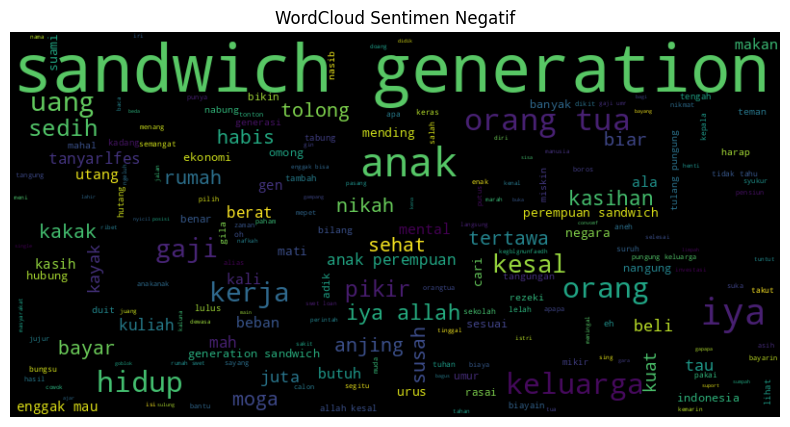

In [ ]:
# Membuat WordCloud untuk sentimen negatif
create_wordcloud(sentimen_negatif, 'WordCloud Sentimen Negatif')

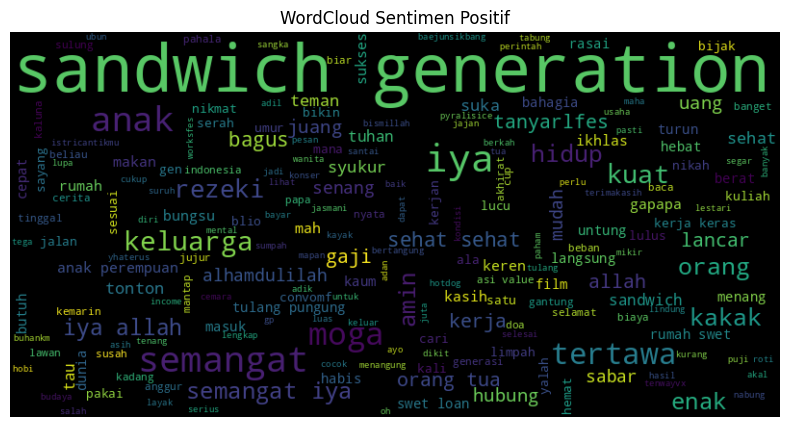

In [ ]:
# Membuat WordCloud untuk sentimen negatif
create_wordcloud(sentimen_positif, 'WordCloud Sentimen Positif')

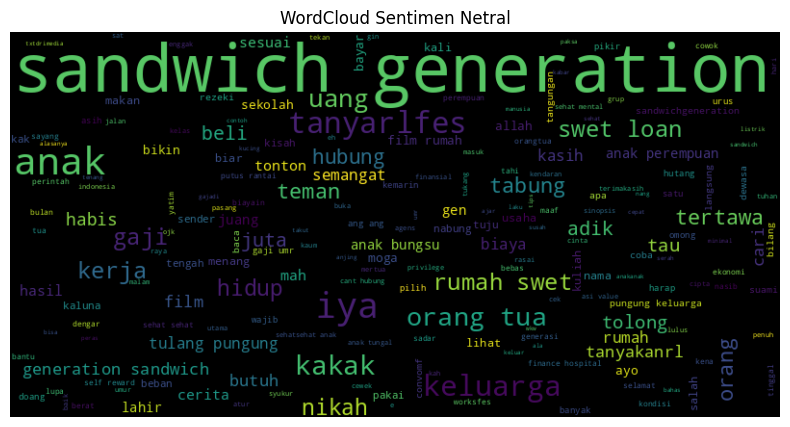

In [ ]:
# Membuat WordCloud untuk sentimen negatif
create_wordcloud(sentimen_netral, 'WordCloud Sentimen Netral')

# Melakukan Test Untuk Memprediksi Teks Baru Dari Model Terbaik

In [ ]:
# Fungsi untuk memproses teks baru dan memprediksi label
def predict_new_text(model, label_encoder, vectorizer, new_text):
    # Memastikan new_text adalah list berisi string
    if isinstance(new_text, str):
        new_text = [new_text]  # Ubah menjadi list jika hanya satu kalimat

    # Vektorisasi teks baru
    new_text_vectorized = vectorizer.transform(new_text).toarray()

    # Bentuk ulang untuk input LSTM
    new_text_reshaped = new_text_vectorized.reshape((new_text_vectorized.shape[0], 1, new_text_vectorized.shape[1]))

    # Melakukan prediksi
    predictions = model.predict(new_text_reshaped)
    predicted_class = np.argmax(predictions, axis=1)

    # Kembalikan label yang sesuai
    predicted_label = label_encoder.inverse_transform(predicted_class)
    return predicted_label

# Penggunaan fungsi untuk memprediksi teks baru
new_input_texts = [
    "Kesal menjadi generasi sandwich",
    "Alhamdulilah masih kuat",
    "Tetap bersyukur kawan"
]

predicted_labels = [predict_new_text(model_nlp_loaded, label_encoder, vectorizer, text) for text in new_input_texts]

for text, label in zip(new_input_texts, predicted_labels):
    print(f"Predicted label for the input text '{text}': {label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted label for the input text 'Kesal menjadi generasi sandwich': Negative
Predicted label for the input text 'Alhamdulilah masih kuat': Positive
Predicted label for the input text 'Tetap bersyukur kawan': Neutral
